###

### 

In [1]:
# Cell 1: Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# Cell 2: Configuration
DATA_DIR = os.path.join('..', 'data', 'audio')
EMOTIONS = ['angry','disgust','fear','happy','neutral','ps','sad']

# Cell 3: Load file paths & labels
paths, labels = [], []
for file in os.listdir(DATA_DIR):
    if not file.endswith('.wav'):
        continue
    paths.append(os.path.join(DATA_DIR, file))
    lbl = file.split('_')[-1].split('.')[0].lower()
    labels.append(lbl)

df = pd.DataFrame({'speech': paths, 'label': labels})

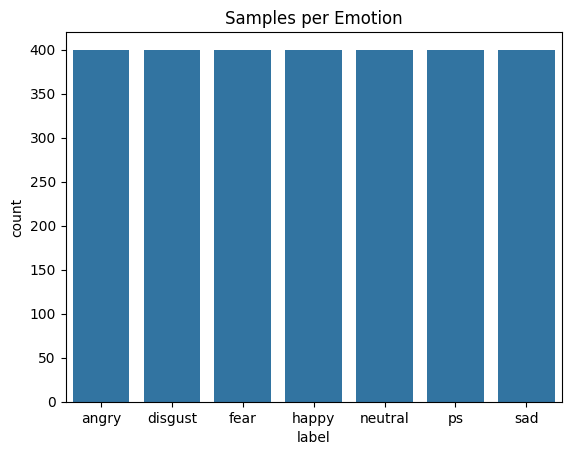

In [4]:
# Cell 4: Quick EDA
sns.countplot(data=df, x='label')
plt.title('Samples per Emotion')
plt.show()

In [9]:
# Cell 5: Feature Extraction
def extract_mfcc(path, n_mfcc=40, duration=3, offset=0.5):
    y, sr = librosa.load(path, duration=duration, offset=offset)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

X = np.array([extract_mfcc(p) for p in df['speech']])
X = np.expand_dims(X, -1)            # shape (N,40,1)

# one-hot encode labels
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

################################################

# after your fit_transform:
y = enc.fit_transform(df[['label']])

# if this is a scipy.sparse matrix, make it dense
if hasattr(y, "toarray"):
    y = y.toarray()

# ensure correct dtype
y = y.astype("float32")

In [10]:
# Cell 6: Build Model
model = Sequential([
    LSTM(256, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(EMOTIONS), activation='softmax')
])
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

c:\Users\Administrator\SoulfulSpixah\speech-emotion-recognition\spixah\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Cell 7: Train with Checkpoint
checkpoint = ModelCheckpoint(
    '../models/best_ser.h5',
    monitor='val_accuracy',
    save_best_only=True
)
history = model.fit(
    X, y,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint]
)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3321 - loss: 1.6595

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.3363 - loss: 1.6505 - val_accuracy: 0.7143 - val_loss: 0.6654
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7732 - loss: 0.6304

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7744 - loss: 0.6273 - val_accuracy: 0.9214 - val_loss: 0.2674
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8929 - loss: 0.3281

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8932 - loss: 0.3271 - val_accuracy: 0.9500 - val_loss: 0.1382
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9385 - loss: 0.2150

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9386 - loss: 0.2147 - val_accuracy: 0.9536 - val_loss: 0.1610
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9484 - loss: 0.1651

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9486 - loss: 0.1647 - val_accuracy: 0.9679 - val_loss: 0.1004
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9415 - loss: 0.1941

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9417 - loss: 0.1934 - val_accuracy: 0.9732 - val_loss: 0.0787
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9657 - loss: 0.1344 - val_accuracy: 0.9625 - val_loss: 0.1582
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9387 - loss: 0.2310

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9389 - loss: 0.2302 - val_accuracy: 0.9804 - val_loss: 0.1001
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9751 - loss: 0.0991 - val_accuracy: 0.9786 - val_loss: 0.0718
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9767 - loss: 0.0739 - val_accuracy: 0.9786 - val_loss: 0.1106
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9574 - loss: 0.1217 - val_accuracy: 0.9804 - val_loss: 0.0756
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9723 - loss: 0.0835 - val_accuracy: 0.9786 - val_loss: 0.0882
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9793 - loss: 0.0642

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9794 - loss: 0.0641 - val_accuracy: 0.9821 - val_loss: 0.0764
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9824 - loss: 0.0706 - val_accuracy: 0.9750 - val_loss: 0.1222
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9841 - loss: 0.0621 - val_accuracy: 0.9768 - val_loss: 0.0944
Epoch 16/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9878 - loss: 0.0434

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9878 - loss: 0.0433 - val_accuracy: 0.9875 - val_loss: 0.0580
Epoch 17/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9842 - loss: 0.0557 - val_accuracy: 0.9875 - val_loss: 0.0543
Epoch 18/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9876 - loss: 0.0532 - val_accuracy: 0.9679 - val_loss: 0.1095
Epoch 19/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9795 - loss: 0.0722 - val_accuracy: 0.9554 - val_loss: 0.1381
Epoch 20/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9640 - loss: 0.0981 - val_accuracy: 0.9786 - val_loss: 0.1022
Epoch 21/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9774 - loss: 0.0735 - val_accuracy: 0.9804 - val_loss: 0.0669
Epoch 22/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9905 - loss: 0.0379

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9905 - loss: 0.0379 - val_accuracy: 0.9893 - val_loss: 0.0606
Epoch 23/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9918 - loss: 0.0332 - val_accuracy: 0.9875 - val_loss: 0.0392
Epoch 24/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9759 - loss: 0.0632 - val_accuracy: 0.9804 - val_loss: 0.0549
Epoch 25/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9883 - loss: 0.0426 - val_accuracy: 0.9821 - val_loss: 0.0578
Epoch 26/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9910 - loss: 0.0219 - val_accuracy: 0.9804 - val_loss: 0.0791
Epoch 27/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9909 - loss: 0.0235 - val_accuracy: 0.9857 - val_loss: 0.0628
Epoch 28/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9952 - loss: 0.0243 - val_accuracy: 0.9786 - val_loss: 0.0859
Epoch 29/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9894 - loss: 0.0375 - val_accuracy: 0.9589 - val_l

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9936 - loss: 0.0156 - val_accuracy: 0.9911 - val_loss: 0.0401
Epoch 42/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9990 - loss: 0.0051 - val_accuracy: 0.9911 - val_loss: 0.0567
Epoch 43/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9911 - val_loss: 0.0511
Epoch 44/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9893 - val_loss: 0.0435
Epoch 45/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9976 - loss: 0.0101 - val_accuracy: 0.9839 - val_loss: 0.1178
Epoch 46/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9957 - loss: 0.0230 - val_accuracy: 0.9768 - val_loss: 0.1468
Epoch 47/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9871 - loss: 0.0486 - val_accuracy: 0.9875 - val_loss: 0.0409
Epoch 48/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9913 - loss: 0.0288 - val_accuracy: 0.9839 - val_l

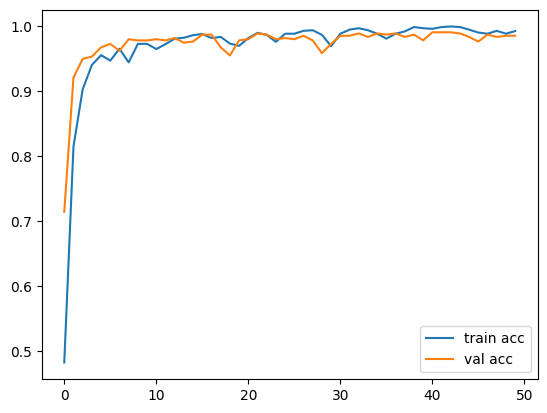

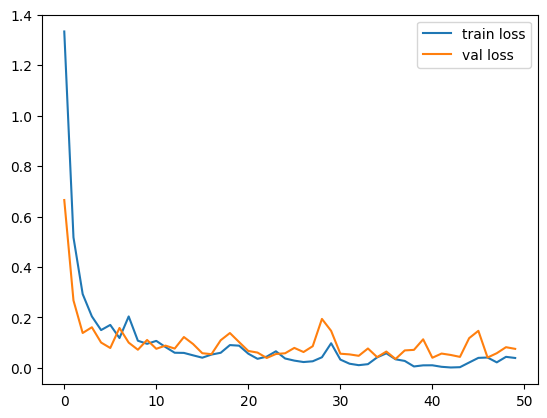

In [12]:
# Cell 8: Plot Results
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend(); plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.show()